In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 50
pd.options.display.max_info_columns = 50
pd.options.display.max_rows = 100

data_source = pd.read_csv(r"data_2022/seasons_stats.csv",encoding='latin-1')
cols = ['Year', 'Player', 'Pos', 'Age', 'G', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP']       
data_source = data_source[cols]
data_source = data_source.query("Year >= 1982 and Year < 2022").reset_index(drop=True)
data_source['Player'] = data_source['Player']
#data_source.info() #20935 rows

In [2]:
data = data_source.copy()
#Drop rows with all missing values 
data.dropna(axis=0,how='all',inplace=True)
#Check for duplicated rows
data.duplicated().any() #False
data.duplicated(subset = ['Year', 'Player']).any() #True 
data = data[~data.duplicated(subset = ['Year', 'Player'], keep = 'first')]
#data.isnull().mean()

In [3]:
#Adding MVP column
mvp_winners_data = pd.read_excel(r"data/mvp_winners.xlsx",header=None,names=['Year','Player'])
mvp_winners_data['Year'] = (mvp_winners_data['Year'].str[:2] + mvp_winners_data['Year'].str[5:]).astype('double')
mvp_winners_data['MVP'] = 1
mvp_winners_data

data['Player'] = data['Player'].str.replace('*','')
data = pd.merge(data,mvp_winners_data,on=['Year','Player'],how='left')
data.loc[(data['Year'] == 2021 ) & ( data["Player"].str.find('Nikola Joki') != -1 ),'MVP'] = 1
data['MVP'] = data['MVP'].fillna(0)

In [ ]:
#Deleting 3 players with NAN that are not significant 
data = data[data['USG%'].notna()]
#Deleting players that didnt make single shot
data['FG%'].fillna(0,inplace=True)
data['2P%'].fillna(0,inplace=True)
data['3P%'].fillna(0,inplace=True)
data['eFG%'].fillna(0,inplace=True)
data['FT%'].fillna(0,inplace=True)
data['TS%'].fillna(0,inplace=True)
data['3PAr'].fillna(0,inplace=True)
data['FTr'].fillna(0,inplace=True)
data['TOV%'].fillna(0,inplace=True)
data.isnull().mean()


In [ ]:
data.to_csv(r"data/cleared_data.csv")
data.info()

In [ ]:
data = pd.read_csv(r"data/cleared_data.csv")
data_eda = data.drop(['Player','Pos'],axis=1)
xd = data_eda.corr() 
#xd['MVP']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

features = data.columns.drop(['MVP','Player','Pos'])
X_train, X_test, y_train, y_test = train_test_split(data, data["MVP"], test_size=0.3, random_state=0)

reg = LinearRegression().fit(X_train[features],y_train)
PredTest = reg.predict(X_test[features])
print( reg.score(X_test[features], y_test) )
print(mean_squared_error(y_test,PredTest))

#reg.coef_

comb = pd.concat([X_test[['Year','Player','MVP']],pd.DataFrame(PredTest,index=X_test.index,columns=["prediction"])],axis=1)
comb.sort_values("prediction",ascending=False).head(20)


In [ ]:
from sklearn.linear_model import Ridge
reg = Ridge().fit(X_train[features],y_train)
PredTest = reg.predict(X_test[features])
print( reg.score(X_test[features], y_test) )
print(mean_squared_error(y_test,PredTest))

#reg.coef_

comb = pd.concat([X_test[['Year','Player','MVP']],pd.DataFrame(PredTest,index=X_test.index,columns=["prediction"])],axis=1)
comb.sort_values("prediction",ascending=False).head(20)



In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 10000).fit(X_train[features],y_train)



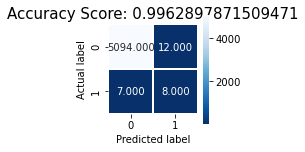

In [26]:
predictions = clf.predict(X_test[features])
score = clf.score(X_test[features], y_test) 
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()

0.997070884592853 0.0029291154071470417


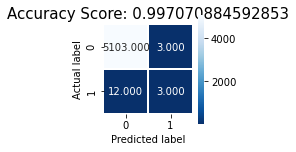

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train[features], y_train)
predictions = forest.predict(X_test[features])
score = forest.score(pd.DataFrame(X_test[features]), y_test)
mse = mean_squared_error(y_test,predictions)

print(score,mse)

cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()

In [13]:
data_back = data.copy()
data_back['id'] = data_back.index

from sklearn.ensemble import RandomForestClassifier

years = range(2000, 2021)
mvp_years = dict()
results_mvp = pd.DataFrame(columns = ['id', 'Year', 'MVP'])

for y in years :
    # train : all seasons from 2000 to year
    # test : year
    train = data_back[data_back.Year < y]
    test = data_back[data_back.Year == y]
    X_train = train.drop(['id', 'Player','Pos','Year', 'MVP'], axis=1)
    y_train = train['MVP']
    X_test = test.drop(['id', 'Player','Pos','Year', 'MVP'], axis=1)
    
    # Random Forest

    random_forest = RandomForestClassifier(n_estimators=10)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest.score(X_train, y_train)
    acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
    
    pred_proba = random_forest.predict_proba(X_test)
    
    y_pred_proba = []
    for i in enumerate(pred_proba):
        y_pred_proba.append(i[1][1])
    y_pred_proba = np.asarray(y_pred_proba)
    
    mvp_years = pd.DataFrame({
        "id": test["id"],
        "Year": y,
        "MVP": y_pred_proba
        })
    
    results_mvp = pd.concat([results_mvp, mvp_years])

results_mvp['id'] = results_mvp['id'].astype('int')
career_player = data_back[['id', 'Player']]
results_mvp = results_mvp.merge(career_player, on='id')

results_mvp = results_mvp.drop_duplicates()
# results_mvp = results_mvp.sort_values(by='MVP', ascending=False)
# results_mvp = results_mvp.iloc[0]

In [14]:
top_mvp = results_mvp.sort_values('MVP', ascending=False).groupby('Year').head(1)
top_mvp = top_mvp.sort_values('Year', ascending=False)
top_mvp = top_mvp[['Year', 'Player']]
top_mvp

,Year,Player
9504,2020,James Harden
8982,2019,James Harden
8743,2018,Russell Westbrook
7969,2017,LeBron James
7378,2016,Stephen Curry
6893,2015,Stephen Curry
6526,2014,LeBron James
6044,2013,LeBron James
5588,2012,LeBron James
5114,2011,Dwight Howard


In [ ]:
predictions = forest.predict(X_test[features])
score = forest.score(pd.DataFrame(X_test[features]), y_test)
mse = mean_squared_error(y_test,predictions)

cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()